Exercise 13.1:
Consider this network. Generate an Erdos-Renyi graph with the same number of nodes and edges. Plot both networks' degree CCDFs, in log-log scale. Discuss the salient differences between these distributions.

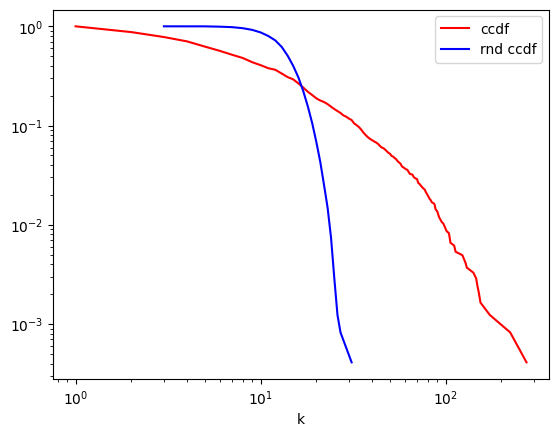

In [85]:
import networkx as nx
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

G = nx.read_edgelist('13_1_data.txt')
n = len(G.nodes)
m = len(G.edges)
G_rnd = nx.gnm_random_graph(n, m)

# https://gist.github.com/mikk-c/f52f5844cff444ae68ced78a6acaf802#file-exercise_13_1-ipynb
def generate_ccdf(G):
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns=("k", "count")).sort_values(by="k") # k = node id, count = degree
    ccdf = dd.sort_values(by="k", ascending=False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by="k")
    return ccdf

G_ccdf = generate_ccdf(G)
G_rnd_ccdf = generate_ccdf(G_rnd)
G_rnd_ccdf["rnd ccdf"] = G_rnd_ccdf["ccdf"]

ax = plt.gca()
G_ccdf.plot(kind='line', x='k', y='ccdf', color='red', loglog=True, ax=ax)
G_rnd_ccdf.plot(kind='line', x='k', y='rnd ccdf', color='blue', loglog=True, ax=ax)
plt.show()
# As we can see, the Gnm graph does not match the real life network. The real network has way more nodes with very high degree and fewer nodes with average.

Exercise 13.4:
Generate an Erdos-Renyi graph with the same number of nodes and edges as the network used for Exercise 13.1. Calculate and compare the networks' clustering coefficients. Compare this with the connection probability p of the random graph (which you should derive from the number of edges and number of nodes using the formula I show in the chapter).

In [86]:
# Reuse the one from above.
G_clust = nx.transitivity(G)
G_rnd_clust = nx.transitivity(G_rnd)
p = (2*m) / (n*(n-1))
print(f"Real graph clustring: {G_clust}")
print(f"Random graph clustring: {G_rnd_clust}")
print(f"Random graph p: {p}")
# As we can see, the clustering is wayy smaller in the random graph. The entire graph is uniform, there are no clusters.
# E.g. despite the random graph having the same number of nodes and edges, the nodes are not clustered in communities.

Real graph clustring: 0.23143166252210473
Random graph clustring: 0.005737367725446604
Random graph p: 0.005653870016403056


Exercise 14.1:
Generate a connected caveman graph with 10 cliques, each with 10 nodes. Generate a small world graph with 100 nodes, each connected to 8 of their neighbors. Add shortcuts for each edge with probability of 0.05. The two graphs have approximately the same number of edges. Compare their clustering coefficients and their average path lengths.

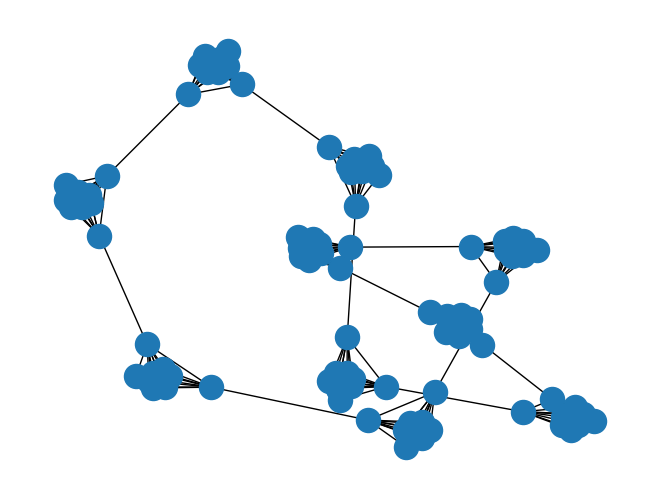

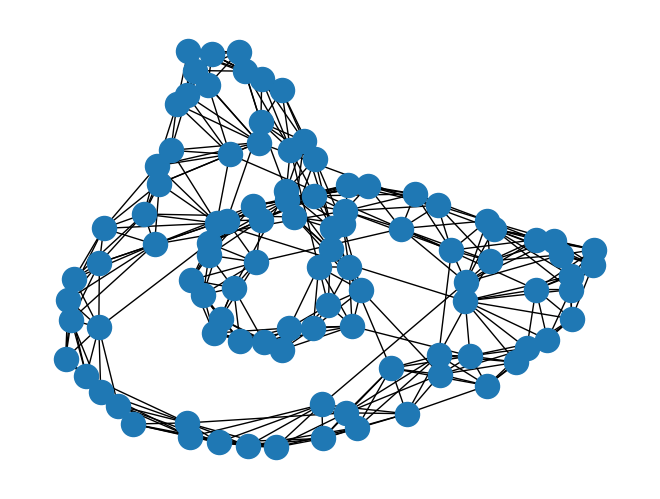

In [87]:
G_cave = nx.connected_caveman_graph(10, 10)
G_world = nx.newman_watts_strogatz_graph(100, 8, 0.05)

plt.figure(1)
nx.draw(G_cave)
plt.figure(2)
nx.draw(G_world)

In [88]:
G_cave_clust = nx.transitivity(G_cave)
G_world_clust = nx.transitivity(G_world)
G_cave_path = nx.average_shortest_path_length(G_cave)
G_world_path = nx.average_shortest_path_length(G_world)
print(f"Cave vs. World clustering: {G_cave_clust:1.3f} vs. {G_world_clust:1.3f}")
print(f"Cave vs. World shortest paht length: {G_cave_path:1.3f} vs. {G_world_path:1.3f}")
# Cave is more clustered, but world has shorter paths. Not surprising.

Cave vs. World clustering: 0.931 vs. 0.583
Cave vs. World shortest paht length: 5.936 vs. 3.388


Exercise 14.2:
Generate a preferential attachment network with 2,000 nodes and average degree of 2. Estimate its degree distribution exponent (you can use either the powerlaw package, or do a simple log-log regression of the CCDF).

In [89]:
from scipy.stats import linregress
import numpy as np

# The answer has m=2, but as you can see by avg_degree that does not give a value of 2 when it is 2.
# The m parameter is the "Number of edges to attach from a new node to existing nodes" (https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html)
# That means the MINIMUM degree is 2 for every node, with higher degrees as more nodes are added.
# It's probably a mistake in the exercise descripiton.
G_pref = nx.barabasi_albert_graph(2000, 1)
avg_degree = sum(dict(G_pref.degree()).values()) / len(G_pref.nodes)
print(f"Average degree is {avg_degree:1.3f}")

pref_ccdf = generate_ccdf(G_pref)
# Do a simple linear regression (we simply want the exponent, not to test whether the power law exists)
# https://gist.github.com/mikk-c/60cf18e4a9a61eb91b8d901c10271260#file-exercise_14_2-ipynb
logcdf = np.log10(pref_ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf['k'], logcdf['ccdf'])
print(f"CCDF Fit: {10 ** log10intercept:1.3f} x ^ {slope:1.3f} (R2 = {r_value ** 2:1.3f}, p = {p_value:1.3f})")

Average degree is 1.999
CCDF Fit: 0.985 x ^ -1.714 (R2 = 0.995, p = 0.000)


Exercise 15.1:
Generate a configuration model with the same degree distribution as this network. Perform the Kolmogorov-Smirnov test between the two degree distributions.

In [90]:
from scipy.stats import ks_2samp

G = nx.read_edgelist('15_1_data.txt')
degree_sequence = sorted(dict(G.degree()).values(), reverse=True)
G_conf = nx.configuration_model(degree_sequence)

degree_distribution_conf = sorted(dict(G_conf.degree()).values(), reverse=True)
ks_2samp(degree_sequence, degree_distribution_conf)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=1, statistic_sign=1)

Exercise 15.2:
Remove the self-loops and parallel edges from the synthetic network you generated in Exercise 15.1 as the configuration model of this network. Note the % of edges you lost. Re-perform the Kolmogorov-Smirnov test with the original network's degree distribution.

In [91]:
old_edges = len(G_conf.edges())
G_conf.remove_edges_from(nx.selfloop_edges(G_conf))
# Create a new simple graph that does not allow duplicate edges
G_conf_new = nx.Graph(G_conf)

new_edges = len(G_conf_new.edges())
loss = old_edges - new_edges
print(f"Removed {loss} edges from graph, {(loss / old_edges)*100:1.2f}%")

degree_distribution_conf = sorted(dict(G_conf_new.degree()).values(), reverse=True)
ks_2samp(degree_sequence, degree_distribution_conf)

Removed 427 edges from graph, 3.41%


KstestResult(statistic=0.007534983853606028, pvalue=0.9999999992780361, statistic_location=71, statistic_sign=-1)

Exercise 15.3:
Generate an LFR benchmark with 100,000 nodes, a degree exponent alpha = 3.13, a community exponent of 1.1, a mixing parameter mu = 0.1, average degree of 10, and maximum degree of 10000. (Note: there's a networkx function to do this). Can you recover the alpha value by fitting the degree distribution?

In [92]:
G_bench = nx.LFR_benchmark_graph(
    100000,
    3.13,
    1.1,
    0.1,
    10,
    max_degree=10000
)
ccdf = generate_ccdf(G_bench)
logcdf = np.log10(ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf['k'], logcdf['ccdf'])
print(f"CCDF Fit: {10 ** log10intercept:1.3f} x ^ {slope:1.3f} (R2 = {r_value ** 2:1.3f}, p = {p_value:1.3f})")
# So the CCDF is defined as: CCDF = 1 - CDF
# If we somehow convert that into the PDF, we get a prediction of alpha pretty close to the original 3.13.
# How do you do that you may ask? I don't know and I'm not gonna spend time figuring it out! (there's probably a bunch of statistics formulas you can apply).

CCDF Fit: 34.618 x ^ -2.169 (R2 = 0.979, p = 0.000)


Exercise 16.1:
Perform 1,000 edge swaps, creating a null version of this network. Make sure you don't create parallel edges. Calculate the Kolmogorov-Smirnov distance between the two degree distributions. Can you tell the difference?

In [99]:
G = nx.read_edgelist('16_1_data.txt')
print(f"Graph is of type {type(G)}")
G_null = nx.double_edge_swap(G, nswap=1000, max_tries=np.inf) # I dont think it can create parallel edges, since only the MultiGraph class supports those

G_distr = sorted(dict(G.degree()).values(), reverse=True)
G_null_distr = sorted(dict(G_null.degree()).values(), reverse=True)
ks_2samp(G_distr, G_null_distr)
# Obliterated

Graph is of type <class 'networkx.classes.graph.Graph'>


KstestResult(statistic=0.0, pvalue=1.0, statistic_location=1, statistic_sign=1)

Exercise 16.2:
Do you get larger KS distances on the network from Exercise 16.1 if you perform 2,000 swaps instead of 1,000? Do you get smaller KS distances if you perform 500?

In [100]:
G_null = nx.double_edge_swap(G, nswap=2000, max_tries=np.inf)

G_distr = sorted(dict(G.degree()).values(), reverse=True)
G_null_distr = sorted(dict(G_null.degree()).values(), reverse=True)
print("2000 swaps", ks_2samp(G_distr, G_null_distr))

G_null = nx.double_edge_swap(G, nswap=500, max_tries=np.inf)

G_distr = sorted(dict(G.degree()).values(), reverse=True)
G_null_distr = sorted(dict(G_null.degree()).values(), reverse=True)
print("500 swaps", ks_2samp(G_distr, G_null_distr))
# would you look at that no fucking difference

2000 swaps KstestResult(statistic=0.0, pvalue=1.0, statistic_location=1, statistic_sign=1)
500 swaps KstestResult(statistic=0.0, pvalue=1.0, statistic_location=1, statistic_sign=1)
